In [11]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from extract_topics import create_bertopic_model
from utils import get_descriptions, get_scores, clean_text, get_gpt_response, get_hallucination_data, get_topic_map, calculate_coherence_score, get_topic_info_summary
from nltk.tokenize import sent_tokenize
import matplotlib as mpl
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
plt.rcParams['font.family'] = 'Arial'

BERTopic is a topic modeling tool that uncovers hidden themes in text data using these steps:

1. **Text Embedding**: Converts text into numerical embeddings using a language model like BERT.
2. **Dimensionality Reduction**: Uses UMAP to reduce embedding dimensions while preserving structure.
3. **Clustering**: Applies HDBSCAN to group similar embeddings into clusters (topics).
4. **Topic Representation**: Extracts representative words for each cluster using c-TF-IDF.
5. **Visualization**: Offers tools to visualize and refine topics.

![BERT Graphic](BERT_graphic.png)

## Hyperparameters

In [12]:
LOAD_PAST_MODEL = True
BERT_MODEL_PATH = 'saved_model/bertopic_model'
PROBS_PATH = 'data/topic_probabilities_max.csv'

NUM_TOPICS = 40 # Set this to None if you want it to decide how many topics
N_NEIGHBORS = 15 # default = 15
N_COMPONENTS = 10 # 2 or 3 is good but you can do more
MIN_DIST = 0.1 # default = 0.1
MIN_TOPIC_SIZE = 30 # Minimum number of documents per topic

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Import the data

In [13]:
data = get_descriptions()
scores = get_scores()

assert len(data) == len(scores)
print(f"Found {len(data)} hallucination descriptions and raw_scores.")
random_index = random.randint(0, len(data))
print(f"Displaying hallucination description from random index {random_index}.")
print(f"Description (Score: {scores[random_index]}): {data[random_index]}")

Found 4365 hallucination descriptions and raw_scores.
Displaying hallucination description from random index 4063.
Description (Score: 10): A tunnel. But the tunnel began expanding, followed by fans of lasers converging to a point, and I could control the point. Then animals, specifically a tiger, vivid bright eyes that seemed to be staring directly at me. Then idk, the universe, space, some massive expanse of what looked like stars, swirling and rotating as if I was moving with great speed in it, a central point of rotation that was void of light or experience. More tunnels, tunnels that would expand rapidly back to the swirling universe, it felt massive and unending, shockingly real and deep. Like I was moving through it. I have a headache now as well.


## Clean the Data

In [14]:
# Import the data and change the column names to id, vividness, and description
df = get_hallucination_data()[['id', 'How would you describe your VISUAL imagery vividness on a scale from 0-10?', 'Please describe as much as you can remember about what you saw in the Ganzflicker:']]
df.columns = ['id', 'vividness', 'description']

# Split the description column up by sentences, keeping the id and vividness columns the same
df['description'] = df['description'].apply(lambda x: sent_tokenize(x))
df = df.explode('description')
df['description'] = df['description'].apply(lambda x: clean_text(x))

In [15]:
df

,id,vividness,description
0,4,0,different vague patterns pulsing the image shi...
1,16,0,mostly a honeycomb of red and black very blurr...
1,16,0,sometimes it went to mostly red in one area an...
2,26,0,a pattern of hexagons that were touching each ...
2,26,0,thick horizontal and vertical lines with fuzzy...
...,...,...,...
4364,4363,10,you know how when they record music they have ...
4364,4363,10,that go up and down with the music
4364,4363,10,i saw that the whole time at the bottom and it...
4364,4363,10,i also saw different shapes and i mages in the...


In [16]:
# Let's look at some examples
description_list = df['description'].to_list()
description_list[:3]

['different vague patterns pulsing the image shifted between mostly yellow to mostly black',
 'mostly a honeycomb of red and black very blurred and moving slowly shifting',
 'sometimes it went to mostly red in one area and that could slide around']

## Create and fit the model

In [17]:
if LOAD_PAST_MODEL:
    topic_model = BERTopic.load(BERT_MODEL_PATH, embedding_model=SentenceTransformer("all-MiniLM-L6-v2"))
else:
    topic_model, topics, probs, umap_model, embedding_model = create_bertopic_model(description_list, number_of_topics=NUM_TOPICS, n_neighbors=N_NEIGHBORS, n_components=N_COMPONENTS, min_dist=MIN_DIST, min_topic_size=MIN_TOPIC_SIZE)

topic_map = get_topic_map(topic_model)
print(f'\nFound {topic_map.items()} topics:')
for topic_number, topic_name in topic_map.items():
        print(f"Topic {topic_number}: {topic_name}")



Found dict_items([(-1, 'Visual Transformations'), (0, 'Visual Patterns'), (1, 'Color Flashes'), (2, 'Morphing Faces'), (3, 'Geometric Shapes'), (4, 'Stars and Galaxies'), (5, 'Unpleasant Experiences'), (6, 'Lines'), (7, 'Spirals and Rotation'), (8, 'Spider Web Patterns'), (9, 'Tunnel'), (10, 'Fractals'), (11, 'Auditory Experiences'), (12, 'Forest Scenery'), (13, 'Visual Perception'), (14, 'Ball of Light'), (15, 'Duration of Events'), (16, 'Perception Limitations'), (17, 'City Skyline'), (18, 'Ocean at Night'), (19, 'Nonsense Expressions'), (20, 'Rotating Flowers'), (21, 'Butterfly Shapes'), (22, 'Space Travel'), (23, 'Moving Hallways'), (24, 'Eye Perceptions'), (25, 'Indifference'), (26, 'Brief Image Clarity')]) topics:
Topic -1: Visual Transformations
Topic 0: Visual Patterns
Topic 1: Color Flashes
Topic 2: Morphing Faces
Topic 3: Geometric Shapes
Topic 4: Stars and Galaxies
Topic 5: Unpleasant Experiences
Topic 6: Lines
Topic 7: Spirals and Rotation
Topic 8: Spider Web Patterns
Topi

## Reduce Outliers and Group Topics

In [18]:
if not LOAD_PAST_MODEL:
    # Get the topics and their numbers
    topic_map = get_topic_map(topic_model)

    for topic_number, topic_name in topic_map.items():
        print(f"Topic {topic_number}: {topic_name}")

    # Reduce outliers
    print(f"Number of outliers before: {sum([1 for i in topics if i[:2] == '-1'])}")
    topics = topic_model.reduce_outliers(description_list, [int(i[:i.index('_')]) for i in topics])
    print(f"Number of outliers after: {sum([1 for i in topics if i == -1])}")

    # Ask GPT to group similar topics together
    prompt = f"""
    Please take the list of topics for Ganzflicker hallucinations and group unspecific and similar topics into groups.
    Examples of topics that should be grouped together:
    1. 'visual imagery experiences', 'visual imagery', 'Visual perception effects', 'Visual perception patterns', 'Visual imagery experiences', 'Visual Imagery experiences', 'Visual imagery effects', 'Visual perception effects', etc.
    2. 'Kaleidoscopic imagery' and 'Fractals and patterns'

    Examples of topics that should not be grouped together because they are unique:
    2. 'Hallucinated faces' and 'Hallway imagery experiences'
    3. 'Floral imagery patterns' and 'Rainbow color imagery'
    4. 'Geometric shapes visualizations' and 'Spiral imagery patterns'
    5. 'Visual imager of fire' and 'Visual imager of eyes'

    If a topic could be considered unique, leave it alone and don't group it with anything else; err on the side of leaving it alone.
    Generic topics like visual imagery should all be in one group. Topics that only differ in minor spelling details should be grouped together.
    Return any groups in a list of lists containing the topic numbers. Return nothing else, just the list of lists to ensure programmatic parsing.
    Example [[1, 2], [3, 4]].
    {topic_map.items()}
    """

    gpt_reponse = get_gpt_response(prompt, temperature=0, model='gpt-4o')

    prompt_2 = f"""
    Please do a second pass to ensure the groupings are valid. 
    **there are always repetitive topics very similar to 'Visual imagery experiences' 
    and 'Visual imagery effects', please pay special attention to put these into the same group.
    Here is the original prompt {prompt} and your inital response {gpt_reponse}.
    Return any groups in a list of lists containing the topic numbers. 
    Return nothing else, just the list of lists to ensure programmatic parsing with similar_topics = eval(gpt_reponse).
    Do not include ```python...```
    """

    gpt_reponse = get_gpt_response(prompt_2, temperature=0, model='gpt-4o')
    print(gpt_reponse)
    similar_topics = eval(gpt_reponse)

    for topic_group in similar_topics:
        if len(topic_group) > 1:
            print("--Topic--")
            for key, value in topic_map.items():    
                if int(key) in topic_group:
                    print(key, value)
    print(topic_map.items())
    
    # Assuming similar_topics is like [[0, 5, 28], [1, 2], [4, 7, 8], ...]
    # and description_list contains your document descriptions/texts
    if similar_topics: # Ensure there are topics to merge
        print(f"Processing all similar topic groups: {similar_topics}")
        topic_model.merge_topics(description_list, similar_topics)
    else:
        print("No topic groups to merge.")

In [19]:
topic_model.get_params()

{'calculate_probabilities': True,
 'ctfidf_model': ClassTfidfTransformer(),
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x366b45d80>,
 'hdbscan_model': <bertopic.cluster._base.BaseCluster at 0x366b46740>,
 'language': None,
 'low_memory': False,
 'min_topic_size': 30,
 'n_gram_range': (1, 1),
 'nr_topics': 40,
 'representation_model': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': <bertopic.dimensionality._base.BaseDimensionalityReduction at 0x366b45f60>,
 'vectorizer_model': CountVectorizer(),
 'verbose': False,
 'zeroshot_min_similarity': 0.7,
 'zeroshot_topic_list': None}

## Calculate Coherence

Check out [Understanding Topic Coherence Measures](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c/) for more information.

It is a score between 0 and 1, where a higher score indicates better modeling.

In [20]:
# Usage
print("First, let's understand your BERTopic model:")
get_topic_info_summary(topic_model)

print("\nNow calculating coherence:")
score = calculate_coherence_score(topic_model, description_list)
if score is not None:
    print(f"\nCoherence Score: {score:.4f}")
else:
    print("\nCould not calculate coherence score")

First, let's understand your BERTopic model:
=== BERTopic Model Summary ===
Number of topics: 28
Topic IDs: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Topic info shape: (28, 5)
Topic info columns: ['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']

First few topics:
   Topic  Count                       Name            Representation  \
0     -1   5340  -1_Visual Transformations  [Visual Transformations]   
1      0   1152          0_Visual Patterns         [Visual Patterns]   
2      1   1110            1_Color Flashes           [Color Flashes]   
3      2    315           2_Morphing Faces          [Morphing Faces]   
4      3    288         3_Geometric Shapes        [Geometric Shapes]   

   Representative_Docs  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
Vocabulary size: 9414
c-TF-IDF matrix shape: (28, 9414)

Now calculating 

## Add the topics to the df

In [26]:
topic_map = get_topic_map(topic_model)

for topic_number, topic_name in topic_map.items():
    print(f"Topic {topic_number}: {topic_name}")

Topic -1: Visual Transformations
Topic 0: Visual Patterns
Topic 1: Color Flashes
Topic 2: Morphing Faces
Topic 3: Geometric Shapes
Topic 4: Stars and Galaxies
Topic 5: Unpleasant Experiences
Topic 6: Lines
Topic 7: Spirals and Rotation
Topic 8: Spider Web Patterns
Topic 9: Tunnel
Topic 10: Fractals
Topic 11: Auditory Experiences
Topic 12: Forest Scenery
Topic 13: Visual Perception
Topic 14: Ball of Light
Topic 15: Duration of Events
Topic 16: Perception Limitations
Topic 17: City Skyline
Topic 18: Ocean at Night
Topic 19: Nonsense Expressions
Topic 20: Rotating Flowers
Topic 21: Butterfly Shapes
Topic 22: Space Travel
Topic 23: Moving Hallways
Topic 24: Eye Perceptions
Topic 25: Indifference
Topic 26: Brief Image Clarity


In [27]:
# Add the topics to the df
df = pd.concat([
    df.reset_index(drop=True),
    topic_model.get_document_info(description_list)[['Topic']].reset_index(drop=True)
], axis=1)

# Rename the column to lowercase 'topic'
df.rename(columns={'Topic': 'topic'}, inplace=True)

# Map the topic values using topic_map
df['topic'] = df['topic'].map(topic_map)
df


,id,vividness,description,topic
0,4,0,different vague patterns pulsing the image shi...,Visual Transformations
1,16,0,mostly a honeycomb of red and black very blurr...,Visual Transformations
2,16,0,sometimes it went to mostly red in one area an...,Visual Transformations
3,26,0,a pattern of hexagons that were touching each ...,Visual Transformations
4,26,0,thick horizontal and vertical lines with fuzzy...,Lines
...,...,...,...,...
10648,4363,10,you know how when they record music they have ...,Visual Transformations
10649,4363,10,that go up and down with the music,Auditory Experiences
10650,4363,10,i saw that the whole time at the bottom and it...,Auditory Experiences
10651,4363,10,i also saw different shapes and i mages in the...,Geometric Shapes


In [39]:
outlier_topic = topic_model.get_topic_info()[topic_model.get_topic_info()['Topic'] == -1]['Representation'][0][0]
print(f"There are {len(df[df['topic'] == outlier_topic])} outlier sentences out of {len(df)} sentences ({len(df[df['topic'] == outlier_topic]) / len(df) * 100 :0f}%)")

There are 5340 outlier sentences out of 10653 sentences (50.126725%)


## Look at some example descriptions for each topic

In [ ]:
examples_to_print = 10
# This only works the first time you train it
if not LOAD_PAST_MODEL:
    # Loop through each row of the DataFrame
    for index, row in topic_model.get_topic_info().iterrows():

        print(f'Topic {row["Topic"]} "{row["Representation"][0]}" Representative Documents:')
        for i in range(examples_to_print):
            print(f"\n{row['Representative_Docs'][i]}")

        print("-" * 30)
else:
    for topic in list(df['topic'].unique()):
        print(f"------Topic: {topic}-------")
        for description in df[df['topic'] == topic].head(examples_to_print)['description']:
            print(f'"{description}"\n')

------Topic: Visual Transformations-------
"different vague patterns pulsing the image shifted between mostly yellow to mostly black"

"mostly a honeycomb of red and black very blurred and moving slowly shifting"

"sometimes it went to mostly red in one area and that could slide around"

"a pattern of hexagons that were touching each other but not overlapping"

"the images were flickering very quickly so its hard for me to recall exactly what they were"

"i saw several shapes on the screen during each quick flicker"

"hard to say"

"not really other colors but more like hues or red and black at different constantly changing flashing spots on the screen that gave the impression of seeing faint shapes or balls of a brighter hue than the background random patterns"

"it reminded me of looking at an optical illusion image the grid illusion where you can see fleeting black circles in the corners of the grid even though there are none"

"my peripheral vision was activating and showing me spi

In [ ]:
# Use this if you want to view more descriptions for a particular topic
chosen_topic = None

filtered_df = df[df['topic'] == chosen_topic]
descriptions_series = filtered_df['description']

print(f"Descriptions for topic '{chosen_topic}':")
for description_text in descriptions_series:
    print(description_text)
    print("--------------------") 

Descriptions for topic 'None':


## Vividness Bins

In [ ]:
# Group vividness scores into bins: 0-3, 4-7, 8-10
def get_vividness_bin(vividness):
    if vividness <= 3:
        return '0-3'
    elif vividness <= 7:
        return '4-7'
    else:
        return '8-10'
# Apply the function to create a new column
df['vividness_bin'] = df['vividness'].apply(get_vividness_bin)

## Visualize results

In [ ]:
df

,id,vividness,description,topic,vividness_bin
0,4,0,different vague patterns pulsing the image shi...,Visual Transformations,0-3
1,16,0,mostly a honeycomb of red and black very blurr...,Visual Transformations,0-3
2,16,0,sometimes it went to mostly red in one area an...,Visual Transformations,0-3
3,26,0,a pattern of hexagons that were touching each ...,Visual Transformations,0-3
4,26,0,thick horizontal and vertical lines with fuzzy...,Lines,0-3
...,...,...,...,...,...
10648,4363,10,you know how when they record music they have ...,Visual Transformations,8-10
10649,4363,10,that go up and down with the music,Auditory Experiences,8-10
10650,4363,10,i saw that the whole time at the bottom and it...,Auditory Experiences,8-10
10651,4363,10,i also saw different shapes and i mages in the...,Geometric Shapes,8-10


In [ ]:
df.groupby('topic').size().reset_index(name='count')

,topic,count
0,Auditory Experiences,131
1,Ball of Light,102
2,Brief Image Clarity,32
3,Butterfly Shapes,39
4,City Skyline,57
5,Color Flashes,1110
6,Duration of Events,72
7,Eye Perceptions,34
8,Forest Scenery,104
9,Fractals,176


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


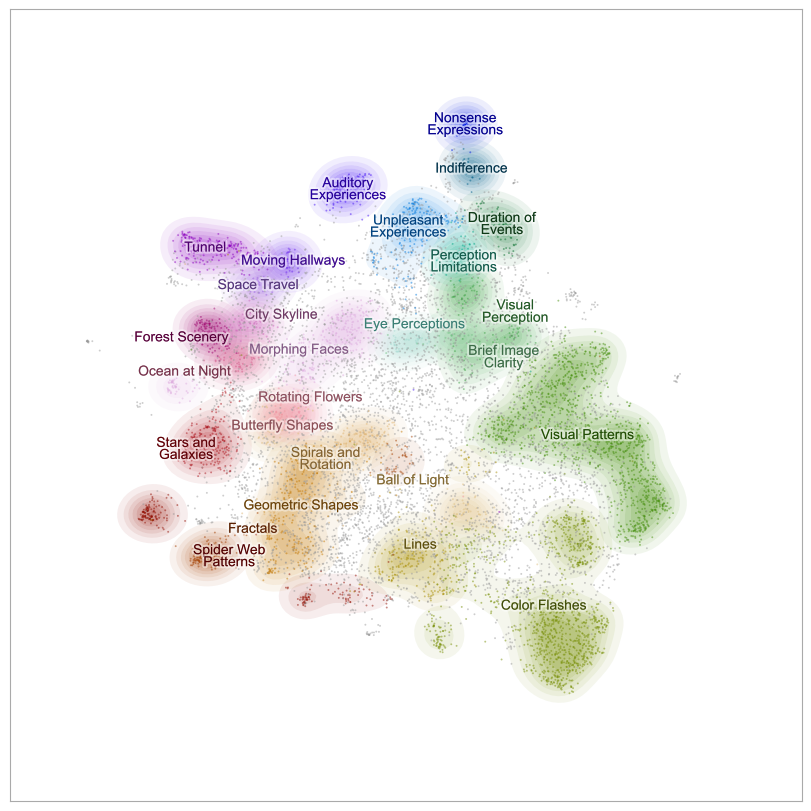

In [ ]:
datamap_kwds = {
    'font_family': 'Arial',
    'label_font_size': 10,
    'label_margin_factor': 1.5,
    'label_linespacing': 1.0,
    'label_over_points': True,
}

graphic = topic_model.visualize_document_datamap(
    description_list,
    title=None,
    width=800,
    height=800,
    datamap_kwds=datamap_kwds
)

In [ ]:
graphic.savefig("topic_map.png", dpi=400, bbox_inches='tight')

In [ ]:
# topic_model.visualize_topics(custom_labels=True)

In [ ]:
new_labels = topic_model.generate_topic_labels(
    topic_prefix=False,
    separator=" "
)

# Set the newly formatted labels as the custom labels for the model.
topic_model.set_topic_labels(new_labels)


# Create the hierarchy visualization.
# custom_labels=True tells the function to use the labels we just set.
fig = topic_model.visualize_hierarchy(custom_labels=True)


# Customize the plot
fig.update_layout(
    title_text=None,                  # Set the plot title.
    title_x=0.5,                      # Center the title.
    xaxis_title="Topic Cosine Distance",
    width=600,                        # Set the plot width in pixels.
    # Set background colors to be fully transparent
    plot_bgcolor='rgba(0,0,0,0)',     
    paper_bgcolor='rgba(0,0,0,0)',    
    font=dict(
        family="Arial",
        size=12,
        color="black"
    )
)

fig.update_xaxes(ticks="")
fig.update_yaxes(ticks="")

# When saving, ensure the format is png to support transparency
fig.write_image("topic_hierarchy.png", scale=4)
fig.show()

# Get topic from each imager score

In [ ]:
# This is the df we will use to plot the data
ids_with_unique_topics = df[['id', 'vividness', 'topic', 'vividness_bin']].drop_duplicates() # Dropping description duplicates so that the same topic isn't counted multiple times for one person
ids_with_unique_topics

,id,vividness,topic,vividness_bin
0,4,0,Visual transformations,0-3
1,16,0,Visual transformations,0-3
3,26,0,Visual transformations,0-3
4,26,0,Lines,0-3
5,26,0,Visual Patterns,0-3
...,...,...,...,...
10646,4350,10,Visual transformations,8-10
10648,4363,10,Visual transformations,8-10
10649,4363,10,Auditory experiences,8-10
10651,4363,10,Geometric Shapes,8-10


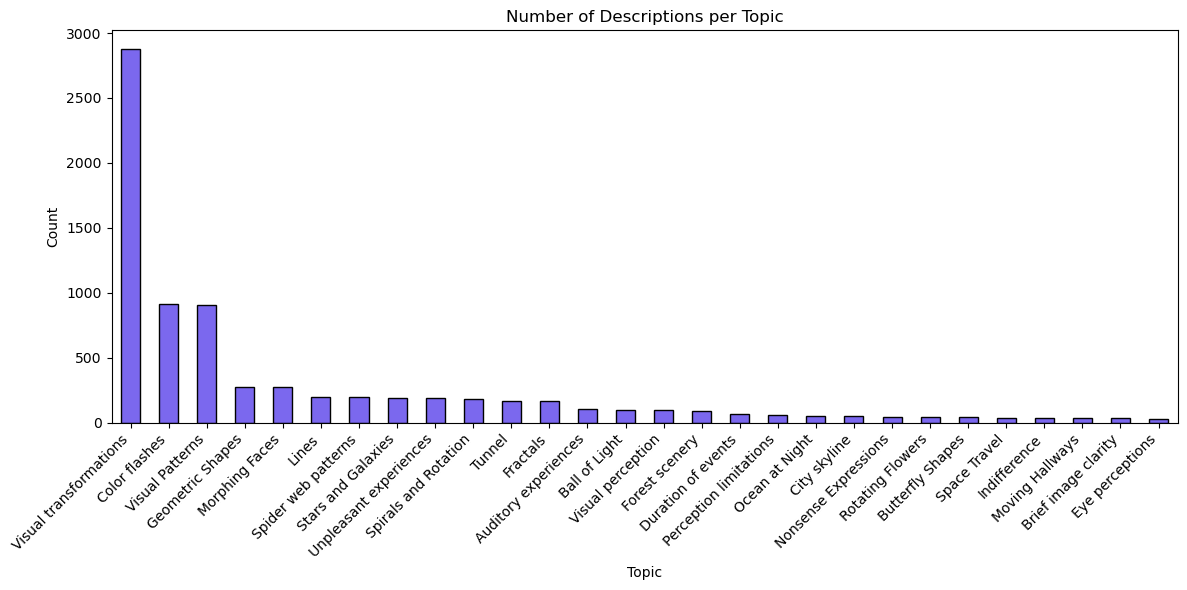

In [ ]:
# Bar chart of topic counts
topic_counts = ids_with_unique_topics['topic'].value_counts()
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='mediumslateblue', edgecolor='black')
plt.title('Number of Descriptions per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Adjustable threshold for minimum percentage to display a topic
PERCENTAGE_THRESHOLD = 10  # Change this value as needed

# First, let's get the unique topics
unique_topics = ids_with_unique_topics['topic'].unique()

# Now, for each vividness score (0-10), calculate the percentage of people with each topic
vividness_scores = sorted(ids_with_unique_topics['vividness'].unique())

# Create a dictionary to store results
results = {}

for topic in unique_topics:
    results[topic] = []
    for score in vividness_scores:
        # Get all unique ids with this vividness score
        ids_with_score = ids_with_unique_topics[ids_with_unique_topics['vividness'] == score]['id'].unique()
        total_people_with_score = len(ids_with_score)
        if total_people_with_score > 0:
            # Count how many unique people with this score have this topic
            people_with_topic = ids_with_unique_topics[(ids_with_unique_topics['vividness'] == score) & (ids_with_unique_topics['topic'] == topic)]['id'].nunique()
            # Calculate percentage
            percentage = (people_with_topic / total_people_with_score) * 100
        else:
            percentage = 0
        results[topic].append(percentage)

# Filter topics: only keep those with at least one value above the threshold
filtered_topics = [topic for topic, vals in results.items() if max(vals) > PERCENTAGE_THRESHOLD]

# Create interactive plot
fig = go.Figure()

# Add a trace for each filtered topic
for topic in filtered_topics:
    fig.add_trace(
        go.Scatter(
            x=vividness_scores, 
            y=results[topic],
            mode='lines+markers',
            name=topic,
            hovertemplate='Vividness: %{x}<br>Percentage: %{y:.1f}%<br>Topic: ' + topic
        )
    )

# Update layout
fig.update_layout(
    title={
        'text': 'Percentage of People Reporting Each Topic by Vividness Score',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Vividness Score',
    yaxis_title='Percentage of People (%)',
    hovermode='closest',
    legend_title='Topics',
    font=dict(size=12),
    height=600,
    width=900,
    margin=dict(t=100)  # Add more top margin
)

# Make x-axis show only integer values
fig.update_xaxes(
    tickmode='linear',
    tick0=0,
    dtick=1
)

# Add buttons to isolate each topic
buttons = [dict(
    label='All Topics',
    method='update',
    args=[{'visible': [True] * len(filtered_topics)},
          {'title': 'Percentage of People Reporting Each Topic by Vividness Score'}]
)]

for i, topic in enumerate(filtered_topics):
    visibility = [False] * len(filtered_topics)
    visibility[i] = True
    buttons.append(dict(
        label=topic,
        method='update',
        args=[{'visible': visibility},
              {'title': f'Percentage of People Reporting \"{topic}\" by Vividness Score'}]
    ))

fig.update_layout(
    updatemenus=[dict(
        type='dropdown',
        direction='down',
        active=0,
        x=0.98,
        y=1.05,
        buttons=buttons
    )]
)

# Add annotation for the dropdown
fig.update_layout(
    annotations=[dict(
        text='Select Topic:',
        x=0.98,
        y=1.10,
        xref='paper',
        yref='paper',
        showarrow=False
    )]
)

# Show the plot
fig.show()

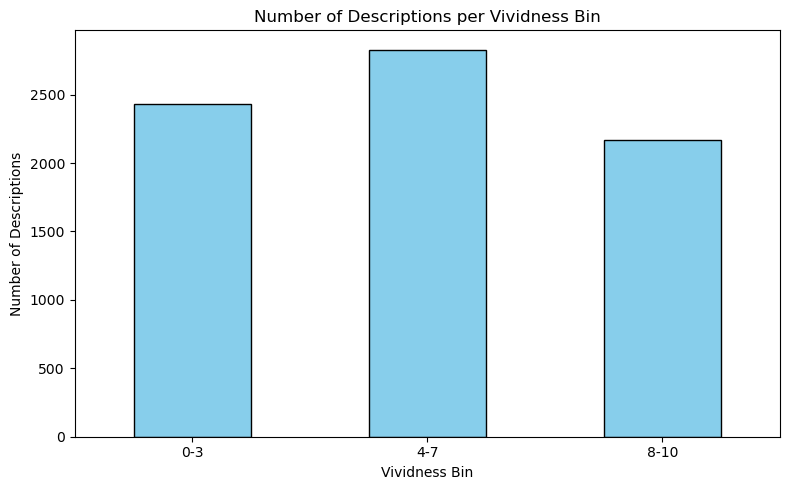

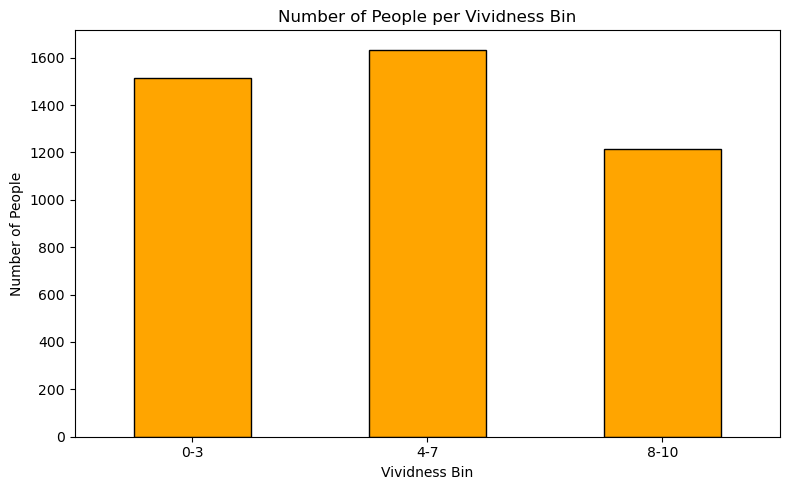

In [ ]:
# Count the number of descriptions in each vividness_bin
vividness_bin_counts = ids_with_unique_topics['vividness_bin'].value_counts().sort_index()

# Count the number of unique ids in each vividness_bin
unique_id_counts = ids_with_unique_topics.groupby('vividness_bin')['id'].nunique().sort_index()

# Plot 1: Number of descriptions per vividness_bin
plt.figure(figsize=(8, 5))
vividness_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Descriptions per Vividness Bin')
plt.xlabel('Vividness Bin')
plt.ylabel('Number of Descriptions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot 2: Number of unique ids per vividness_bin
plt.figure(figsize=(8, 5))
unique_id_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Number of People per Vividness Bin')
plt.xlabel('Vividness Bin')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Topic Description Counts:
topic
Visual transformations    2877
Color flashes              911
Visual Patterns            902
Geometric Shapes           275
Morphing Faces             273
Lines                      199
Spider web patterns        198
Stars and Galaxies         191
Unpleasant experiences     188
Spirals and Rotation       181
Tunnel                     165
Fractals                   164
Auditory experiences       107
Ball of Light               99
Visual perception           95
Forest scenery              92
Duration of events          64
Perception limitations      55
Ocean at Night              52
City skyline                52
Nonsense Expressions        45
Rotating Flowers            41
Butterfly Shapes            39
Space Travel                36
Indifference                33
Moving Hallways             33
Brief image clarity         32
Eye perceptions             31
Name: count, dtype: int64
------------------------------

Generating plots for description count ran

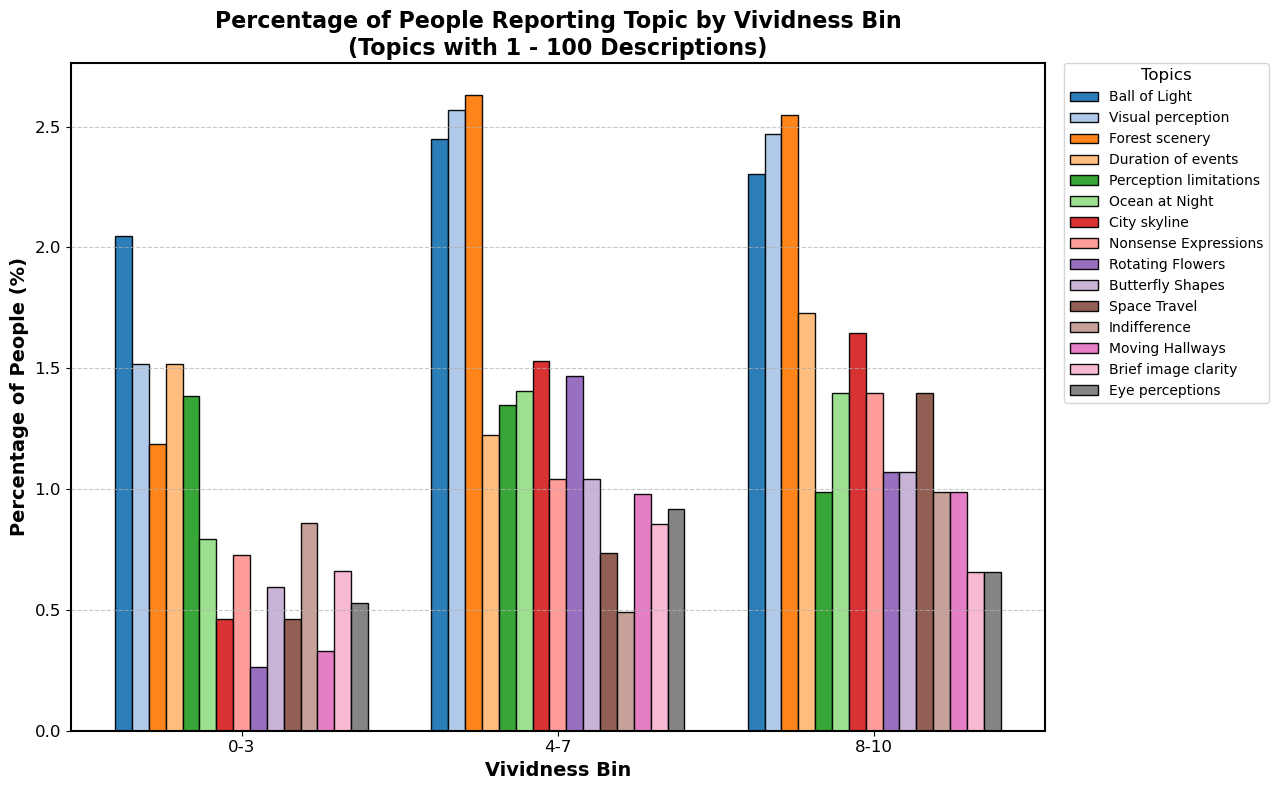


Plotting for: Topics with 101 - 150 Descriptions
Topics: ['Auditory experiences']


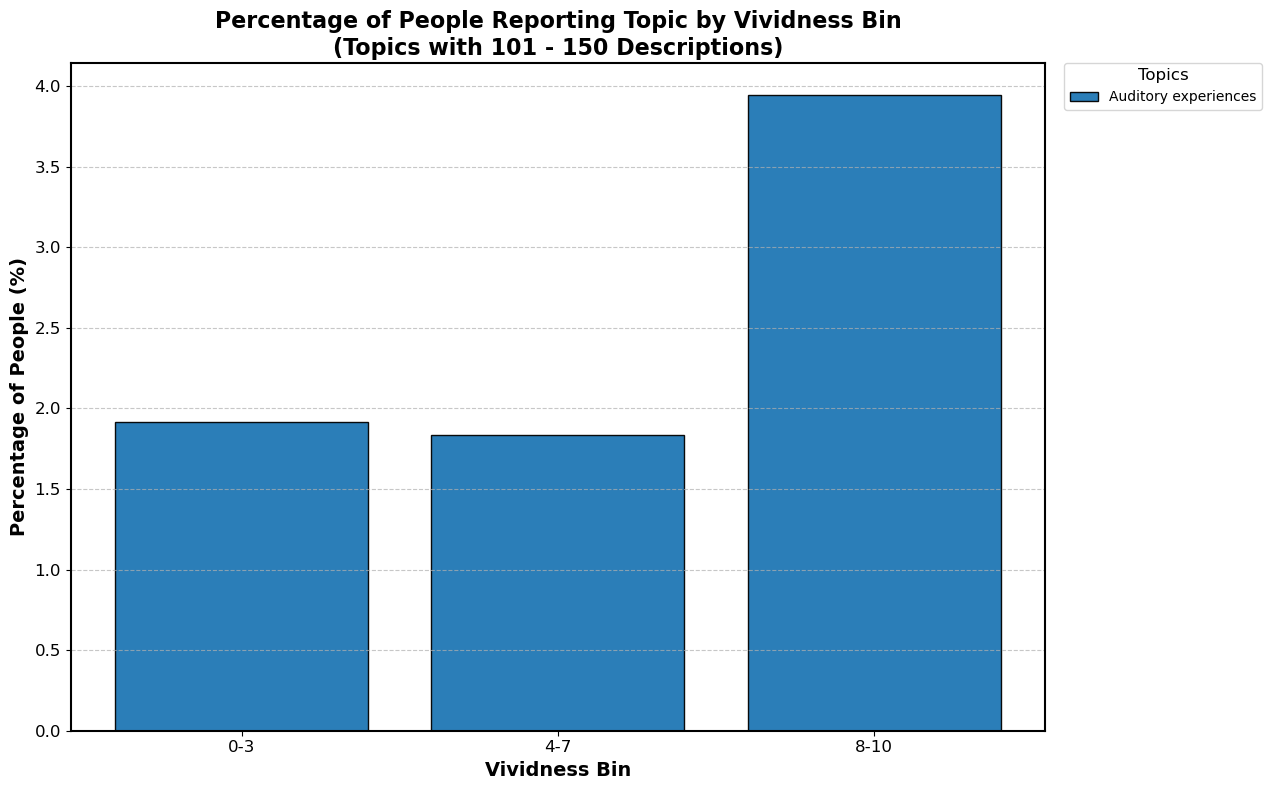


Plotting for: Topics with 151 - 200 Descriptions
Topics: ['Lines', 'Spider web patterns', 'Stars and Galaxies', 'Unpleasant experiences', 'Spirals and Rotation', 'Tunnel', 'Fractals']


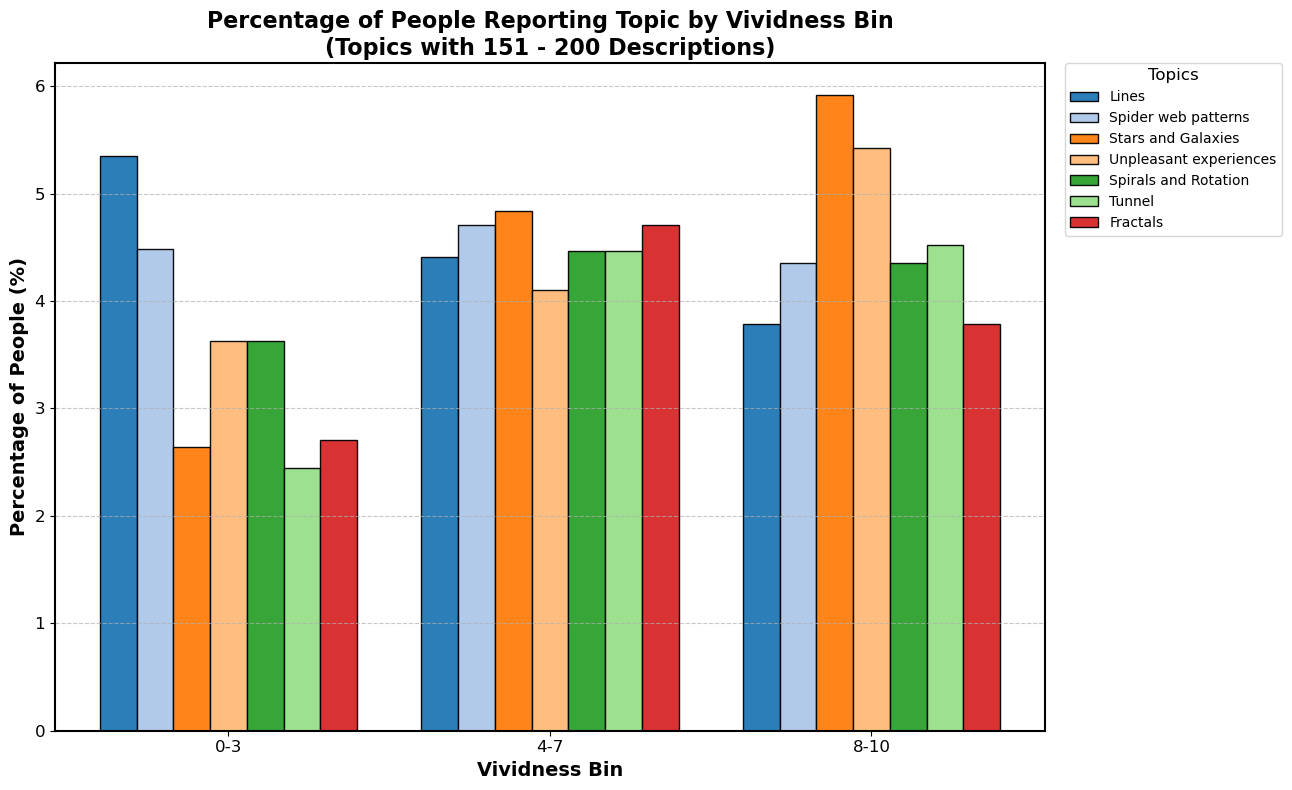

No topics found for description range (200, 250]. Skipping plot for: Topics with 201 - 250 Descriptions
No data to plot for: Percentage of People Reporting Topic by Vividness Bin
(Topics with 201 - 250 Descriptions)


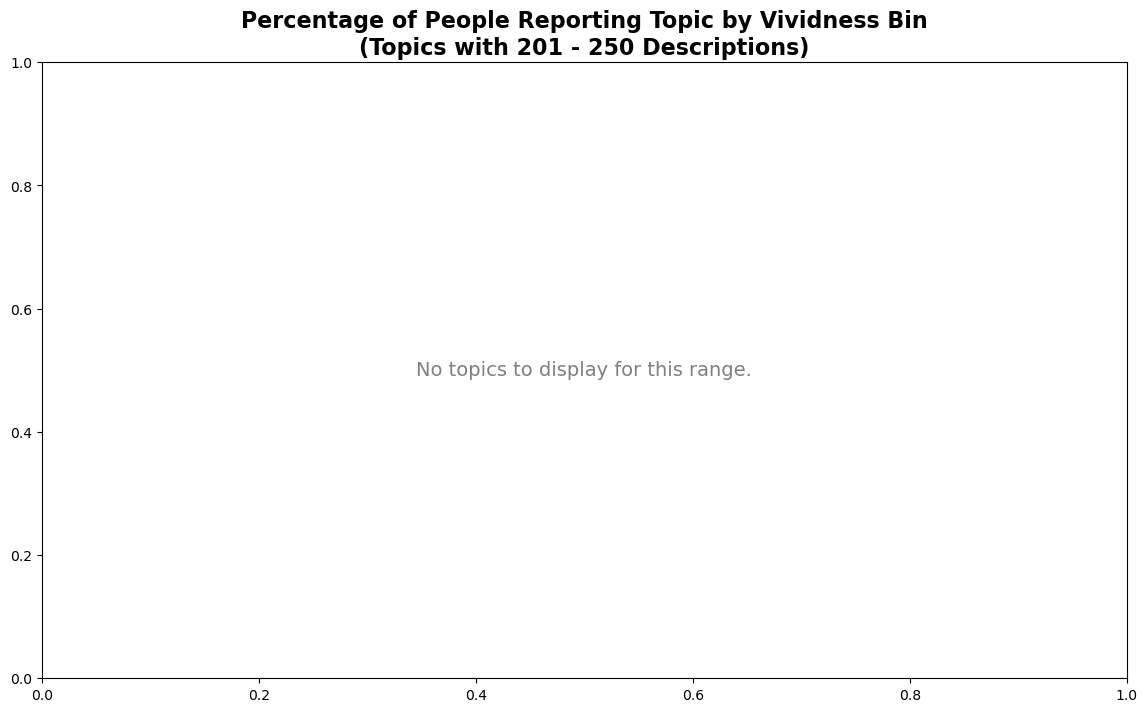


Plotting for: Topics with > 250 Descriptions
Topics: ['Visual transformations', 'Color flashes', 'Visual Patterns', 'Geometric Shapes', 'Morphing Faces']


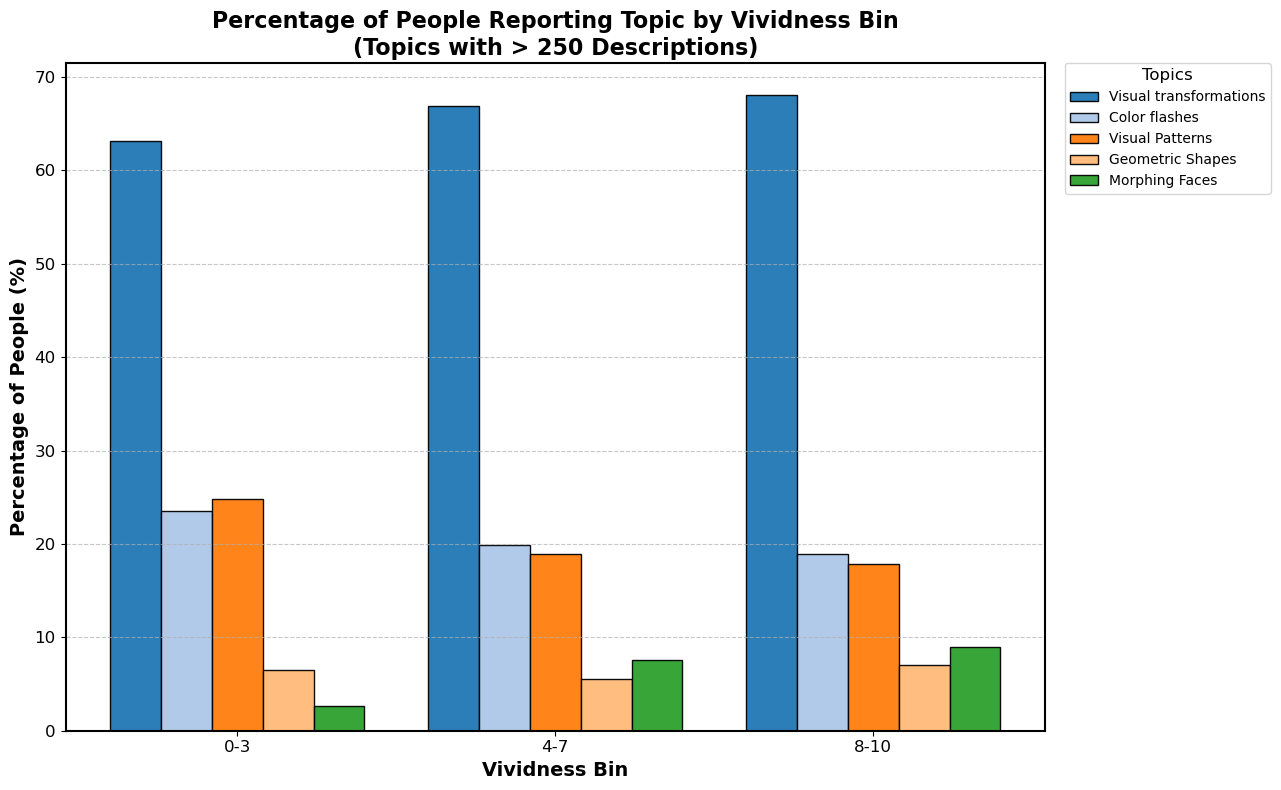


All plots generated.


In [ ]:
DESCRIPTION_COUNT_BINS = [100, 150, 200, 250]  # Define your description count thresholds


def create_topic_bar_chart(topics_to_plot, plot_data_df, vividness_scores_list, chart_title):
    """
    Generates and displays a single bar chart for the given topics and data.
    """
    if not topics_to_plot or plot_data_df.empty:
        print(f"No data to plot for: {chart_title}")
        # Optionally, create an empty plot with a message
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.text(0.5, 0.5, "No topics to display for this range.",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=14, color='gray')
        ax.set_title(chart_title, fontsize=16, fontweight='bold')
        plt.show()
        return

    fig, ax = plt.subplots(figsize=(14, 8))
    
    num_topics_on_chart = len(topics_to_plot)
    
    # Color palette
    tableau_colors = list(mpl.colormaps['tab20'].colors)
    if num_topics_on_chart > len(tableau_colors):
        extended_palette = tableau_colors * (num_topics_on_chart // len(tableau_colors) + 1)
        plot_colors = extended_palette[:num_topics_on_chart]
    else:
        plot_colors = tableau_colors[:num_topics_on_chart]

    # Bar width and positions
    bar_group_width_factor = 0.8
    bar_width = bar_group_width_factor / num_topics_on_chart if num_topics_on_chart > 0 else bar_group_width_factor
    positions = np.arange(len(vividness_scores_list))

    # Plotting bars
    for i, topic_name in enumerate(topics_to_plot):
        if topic_name not in plot_data_df.columns:
            print(f"Warning: Topic '{topic_name}' not found in plot_data_df for chart '{chart_title}'. Skipping.")
            continue
            
        offset = bar_width * (i - (num_topics_on_chart - 1) / 2.0)
        color_val = plot_colors[i % len(plot_colors)]
        
        ax.bar(positions + offset, plot_data_df[topic_name], width=bar_width,
               color=color_val,
               label=topic_name,
               edgecolor='black',
               alpha=0.95)

    # Labels, title, ticks
    ax.set_xlabel('Vividness Bin', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage of People (%)', fontsize=14, fontweight='bold')
    ax.set_title(chart_title, fontsize=16, fontweight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels(vividness_scores_list, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Legend
    if num_topics_on_chart > 0 :
        ax.legend(title='Topics', loc='upper left', bbox_to_anchor=(1.02, 1),
                  fontsize=10, title_fontsize=12, borderaxespad=0.) # Reduced legend font size

    # Grid and border
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    # Layout adjustments
    plt.tight_layout()
    if num_topics_on_chart > 0:
        # Adjust 'right' to make space for the legend.
        # The amount of space needed can depend on the length of the longest topic name.
        # This is an approximation.
        max_topic_len = 0
        if topics_to_plot: # Ensure topics_to_plot is not empty
             max_topic_len = len(max(topics_to_plot, key=len, default=""))
        
        if max_topic_len > 25:
            right_adjust = 0.70
        elif max_topic_len > 15:
            right_adjust = 0.75
        else:
            right_adjust = 0.80
        plt.subplots_adjust(right=right_adjust)


    plt.show()

# 1. Get unique topics and vividness bins
all_unique_topics = ids_with_unique_topics['topic'].unique()
vividness_scores = sorted(ids_with_unique_topics['vividness_bin'].unique())

# 2. Calculate the number of descriptions for each topic
topic_description_counts = ids_with_unique_topics['topic'].value_counts()
print("Topic Description Counts:")
print(topic_description_counts)
print("-" * 30)

# 3. Calculate the percentage of people with each topic for each vividness bin (globally)
all_results_by_topic = {}
for topic_name in all_unique_topics:
    all_results_by_topic[topic_name] = []
    for score_val in vividness_scores:
        ids_with_score = ids_with_unique_topics[ids_with_unique_topics['vividness_bin'] == score_val]['id'].unique()
        total_people_with_score = len(ids_with_score)
        
        if total_people_with_score > 0:
            people_with_topic_in_bin = ids_with_unique_topics[(ids_with_unique_topics['vividness_bin'] == score_val) & (ids_with_unique_topics['topic'] == topic_name)]['id'].nunique()
            percentage = (people_with_topic_in_bin / total_people_with_score) * 100
        else:
            percentage = 0
        all_results_by_topic[topic_name].append(percentage)

# 4. Define description count ranges for plotting
# Bins: e.g., [50, 100, 150] -> Ranges: (0, 50], (50, 100], (100, 150], (150, inf]
plot_ranges = []
lower_bound = 0
for upper_thresh in DESCRIPTION_COUNT_BINS:
    plot_ranges.append((lower_bound, upper_thresh))
    lower_bound = upper_thresh
plot_ranges.append((lower_bound, float('inf'))) # Add the last range (e.g., 150 and above)

print(f"\nGenerating plots for description count ranges: {plot_ranges}")
print("-" * 30)

# 5. Loop through ranges, filter topics, and plot
for r_low, r_high in plot_ranges:
    topics_for_current_range = [
        topic for topic, count in topic_description_counts.items()
        if (count > r_low and count <= r_high)
    ]
    
    # Construct title for the current plot
    if r_high == float('inf'):
        range_title_str = f"Topics with > {r_low} Descriptions"
    elif r_low == 0:
        # For the first bin, we want to include topics with count = 1 up to r_high
        # The condition `count > r_low` (i.e. >0) handles this.
        range_title_str = f"Topics with 1 - {r_high} Descriptions"
    else:
        range_title_str = f"Topics with {r_low + 1} - {r_high} Descriptions"
    
    full_chart_title = f"Percentage of People Reporting Topic by Vividness Bin\n({range_title_str})"

    if not topics_for_current_range:
        print(f"No topics found for description range ({r_low}, {r_high}]. Skipping plot for: {range_title_str}")
        create_topic_bar_chart([], pd.DataFrame(index=vividness_scores), vividness_scores, full_chart_title)
        continue

    # Filter the global results for the current set of topics
    current_range_results = {
        topic: all_results_by_topic[topic] 
        for topic in topics_for_current_range 
        if topic in all_results_by_topic # Ensure topic exists in results
    }
    
    if not current_range_results: 
        print(f"No percentage data found for topics in range ({r_low}, {r_high}]. Skipping plot for: {range_title_str}")
        create_topic_bar_chart([], pd.DataFrame(index=vividness_scores), vividness_scores, full_chart_title)
        continue

    current_plot_df = pd.DataFrame(current_range_results, index=vividness_scores)
    
    print(f"\nPlotting for: {range_title_str}")
    print(f"Topics: {topics_for_current_range}")
    
    create_topic_bar_chart(topics_for_current_range, current_plot_df, vividness_scores, full_chart_title)

print("\nAll plots generated.")



## Get the Raw Probabilities

We need to do this again because we've changed the topics since we last got probs

In [ ]:
df

,id,vividness,description,topic,vividness_bin
0,4,0,different vague patterns pulsing the image shi...,Visual transformations,0-3
1,16,0,mostly a honeycomb of red and black very blurr...,Visual transformations,0-3
2,16,0,sometimes it went to mostly red in one area an...,Visual transformations,0-3
3,26,0,a pattern of hexagons that were touching each ...,Visual transformations,0-3
4,26,0,thick horizontal and vertical lines with fuzzy...,Lines,0-3
...,...,...,...,...,...
10648,4363,10,you know how when they record music they have ...,Visual transformations,8-10
10649,4363,10,that go up and down with the music,Auditory experiences,8-10
10650,4363,10,i saw that the whole time at the bottom and it...,Auditory experiences,8-10
10651,4363,10,i also saw different shapes and i mages in the...,Geometric Shapes,8-10


In [ ]:
if LOAD_PAST_MODEL:
    topic_list = list(get_topic_map(topic_model, include_outlier=True).values())
else:
    topic_list = list(get_topic_map(topic_model, include_outlier=False).values())

topics, probs = topic_model.transform(description_list)

print(f"There are {len(topic_list)} topics.")
prob_df = pd.DataFrame(probs, columns=topic_list)

prob_df = pd.concat([df[['id']], prob_df], axis=1)
prob_df = prob_df.groupby('id').max().reset_index()

hallucinations_df = get_hallucination_data()
result = hallucinations_df.merge(prob_df, how='left', on='id')
result['vividness_bin'] = result['How would you describe your VISUAL imagery vividness on a scale from 0-10?'].apply(get_vividness_bin)


result.to_csv(PROBS_PATH, index=False)
print(f"Saved probabilities to {PROBS_PATH}!")

There are 28 topics.
Saved probabilities to data/topic_probabilities_max.csv!


## Save the model

In [ ]:
if not LOAD_PAST_MODEL:
    topic_model.save(BERT_MODEL_PATH, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)